In [1]:
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.mae_dataloader import  kids450_files_cluster, mae_kids450
from my_utils.mae_collate import mae_collate_fn
from torch.utils.data import Dataset, DataLoader
#from my_utils.models import Regression_model, Regression_model_2
from torchvision import datasets, transforms, models
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torchsummary
#print(torchsummary.__version__)

In [4]:
import sys
print(sys.path)

['/python', '', '/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python311.zip', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/lib-dynload', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages']


Use the same dataloader and dataset as for the supervised task for the simclr.

In [5]:
#file_paths
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128

train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  mae_kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)

print(f'Length of test data: {len(test_data)}')

Length of test data: 114000


In [6]:
dl = kids_test_loader
for i,(x,y) in enumerate(dl):
    print(len(dl))
    #random.shuffle(dg.file_paths)
    print(x.shape)
    print(y.shape)
    if i == 1:
        break

593
torch.Size([192, 1, 4, 128, 128])
torch.Size([192, 2])
593
torch.Size([192, 1, 4, 128, 128])
torch.Size([192, 2])


In [7]:
x[0].squeeze(0).shape

torch.Size([4, 128, 128])

Test and printout images

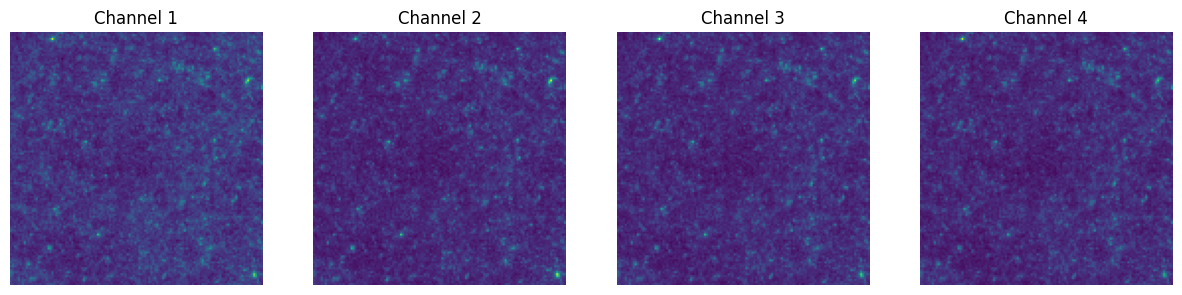

In [8]:
# Plot each image
test_im = x[13].squeeze()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

Show it as one image

In [12]:
PATCH_SIZE = 16

In [13]:


def get_train_augmentation_model():
    model = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),#random flip same as 180 degrees
                                    transforms.RandomApply([transforms.RandomRotation((270, 270))], p=0.5),
                                    transforms.RandomApply([transforms.RandomRotation((90, 90))], p=0.5),
                                    transforms.RandomCrop(10),
                                    #AddGaussianNoise(mean=0., std=1.)
                                    ]) 
    return model

def get_test_augmentation_model():
    model = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),#random flip same as 180 degrees
                                    transforms.RandomApply([transforms.RandomRotation((270, 270))], p=0.5),
                                    transforms.RandomApply([transforms.RandomRotation((90, 90))], p=0.5),
                                    transforms.RandomCrop(10),
                                    #AddGaussianNoise(mean=0., std=1.)
                               ])
    return model

class Patches(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, images):
        # Create patches from the input images
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        #patch_area = self.patch_size* self.patch_size
        #patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, num_patches_height * num_patches_width, patch_area)
        #print(f"before contigoius: {patches.shape}")
        patches = patches.contiguous()
        #print(f"after contigoius: {patches.shape}")
        patches = patches.view(images.size(0), -1, self.patch_size * self.patch_size * 3)
        #print(f"after reshape: {patches.shape}")
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(ToPILImage()(images[idx].cpu()))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            #patch_img = patch.view(self.patch_size, self.patch_size, 3).cpu()
            patch_img = patch.view(3,self.patch_size, self.patch_size).cpu()
            #print(patch_img.shape)
            plt.imshow(ToPILImage()(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

#def reconstruct_from_patch(self, patch):
#    # This utility function takes patches from a *single* image and
#    # reconstructs it back into the image. This is useful for the train
#    # monitor callback.
#    num_patches = patch.size(0)
#    n = int(np.sqrt(num_patches))
#    patch = patch.view(num_patches, self.patch_size, self.patch_size, 3)
#    rows = torch.split(patch, n, dim=0)
#    rows = [torch.cat(list(row), dim=1) for row in rows]
#    reconstructed = torch.cat(rows, dim=0)
#    return reconstructed
#    
#    

torch.Size([4, 3, 32, 32])
torch.Size([4, 4, 768])
Index selected: 1.


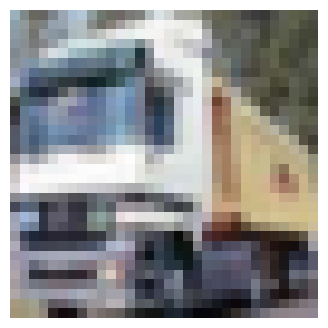

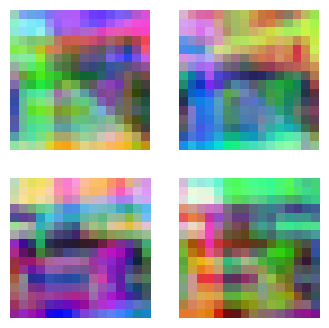

1

In [254]:
# Example usage
PATCH_SIZE = 16

# Assuming you have a batch of images in `images` tensor
#images = torch.rand(8, 3, 128, 128)  # Example batch of images
#images = x_images
images = cifar_im#.permute(0, 2, 3, 1) 
print(images.shape)
patch_layer = Patches(patch_size=PATCH_SIZE)
patches = patch_layer(images)
print(patches.shape)
#len(patches[2])

patch_layer.show_patched_image(images, patches)

#reconstructed_image = patch_layer.reconstruct_from_patch(patches[0])
#reconstructed_image = reconstructed_image.view(reconstructed_image.shape[2],reconstructed_image.shape[1],reconstructed_image.shape[0])
#plt.imshow(ToPILImage()(reconstructed_image.cpu()))
#plt.axis("off")
#plt.show()

In [72]:
def remove_channel(tensor, channel_to_remove):
    """
    Remove a specific channel from a PyTorch tensor representing images.
    
    Args:
    - tensor (torch.Tensor): Input tensor with shape [batch_size, channels, height, width].
    - channel_to_remove (int): Index of the channel to remove.
    
    Returns:
    - torch.Tensor: Tensor with the specified channel removed, shape [batch_size, channels-1, height, width].
    """
    # Ensure channel_to_remove is within valid range
    assert 0 <= channel_to_remove < tensor.size(1), f"Invalid channel index: {channel_to_remove}"
    
    # Method 1: Using torch.cat and torch.unbind
    tensor_without_channel = torch.cat((tensor[:, :channel_to_remove], tensor[:, channel_to_remove+1:]), dim=1)
    
    # Alternative Method 2: Using torch.index_select
    # indices = list(range(tensor.size(1)))  # Create a list of indices [0, 1, 2, ...]
    # indices.pop(channel_to_remove)  # Remove the specified channel index
    # tensor_without_channel = torch.index_select(tensor, 1, torch.tensor(indices))
    
    return tensor_without_channel
    

In [95]:
x_images = x[:8].squeeze()
x_images = remove_channel(x_images, 3)
#x_images = remove_channel(x_images, 2)
#x_images = remove_channel(x_images, 1)
x_images.shape

torch.Size([8, 3, 128, 128])

In [197]:
images = cifar_im.permute(0, 2, 3, 1) 
print(images.shape)

torch.Size([4, 32, 32, 3])


torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 2, 2, 16, 16])
Index selected: 2.


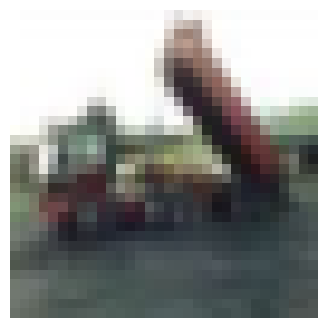

RuntimeError: shape '[3, 16, 16]' is invalid for input of size 1024

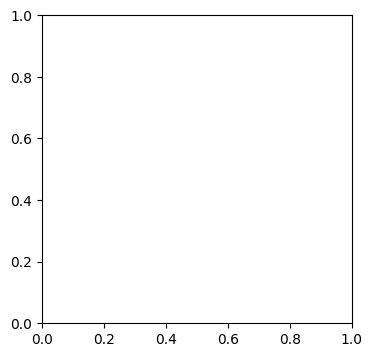

In [171]:
cifar_im.shape

torch.Size([4, 3, 32, 32])

In [226]:
cifar_im2 = cifar_im[1].unsqueeze(0)
patch = Patchify(patch_size = 16)
patched = patch(cifar_im2)
patched.shape

after torch.Size([1, 768, 4])


torch.Size([1, 4, 3, 16, 16])

In [300]:
class Patches_2(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, images):
        bs, c, h, w = images.shape
        patches = self.unfold(images)
        patches = patches.view(bs, c, self.patch_size,self.patch_size, -1).permute(0,4,1,2,3)   
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        plt.figure(figsize=(4, 4))
        #print(f"plotting image{images.shape}")
        plt.imshow(ToPILImage()(images.squeeze().cpu()))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1])) #calc number of rows/cols
        #print(f"n {n}")
        fig = plt.figure(figsize=(4, 4))
        grid = ImageGrid(fig, 111, nrows_ncols = (n,n), axes_pad = 0.1)
        
        for i, ax in enumerate(grid):
            patch = patches.squeeze()[i] 
            patch = patch.permute(1, 2, 0).numpy() #change shape
            #print(f"after changing shape{patch.shape}")
            ax.imshow(patch)
            ax.axis("off")
            plt.axis("off")
        plt.show()


torch.Size([1, 196, 3, 16, 16])


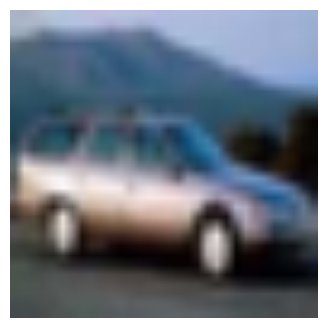

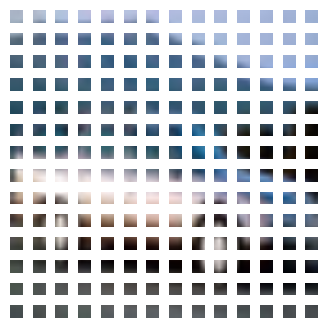

In [107]:
PATCH_SIZE = 16

patch_layer = Patches_2(patch_size=PATCH_SIZE)
patches = patch_layer(images)
print(patches.shape)


patch_layer.show_patched_image(images, patches)

In [ ]:
cifar_im2 = cifar_im[1].unsqueeze(0)
patch = Patchify(patch_size = 16)
patched = patch(cifar_im2)
patched.shape

shape torch.Size([1, 3, 32, 32])
bs:1
after torch.Size([1, 768, 4])
torch.Size([1, 4, 3, 16, 16])


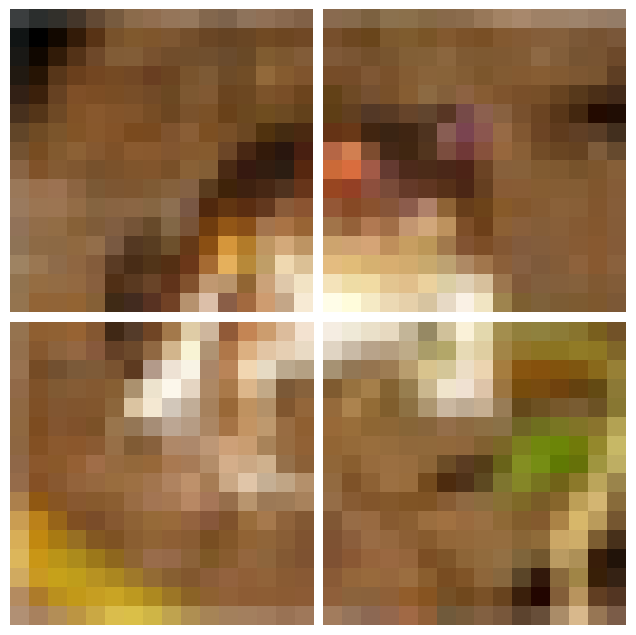

torch.Size([1, 4, 3, 16, 16])

In [263]:
class Patchify(nn.Module):
    def __init__(self, patch_size=56):
        super().__init__()
        self.p = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x -> B c h w
        bs, c, h, w = x.shape
        print(f"bs:{bs}")
        
        x = self.unfold(x)
        print(f"after {x.shape}")
        # x -> B (c*p*p) L
        
        # Reshaping into the shape we want
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        print(a.shape)
        # a -> ( B no.of patches c p p )
        return a


def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.1)#must be changed

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).numpy() 
        #print(patch.shape)
        ax.imshow(patch)
        ax.axis('off')

    plt.show()


cifar_im2 = cifar_im[0].unsqueeze(0)
patch = Patchify(patch_size = 16)
print(f"shape {cifar_im2.shape}")
patched = patch(cifar_im2)

plot_patches(patched.squeeze(0))
patched.shape

torch.Size([1, 3, 32, 32])
torch.Size([1, 4, 3, 16, 16])


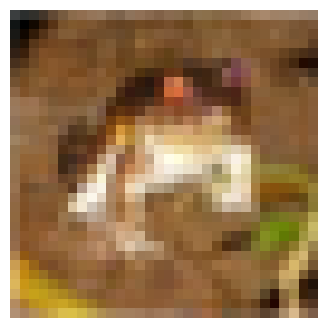

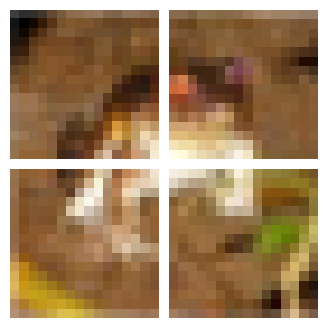

In [307]:
PATCH_SIZE = 16

images =  cifar_im[0].unsqueeze(0)
print(images.shape)
patch_layer = Patches_2(patch_size=PATCH_SIZE)
patches = patch_layer(images)
print(patches.shape)
#len(patches[2])

patch_layer.show_patched_image(images, patches)



In [144]:
patches.shape

torch.Size([4, 4, 768])

In [15]:
augmentation_model = get_train_augmentation_model()

In [21]:
x.shape.squeez

torch.Size([192, 1, 4, 128, 128])

In [22]:
x_test = augmentation_model(x.squeeze())
x_test.shape

torch.Size([192, 4, 10, 10])

torch.Size([3, 128, 128])


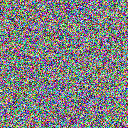

In [49]:
import torch
from torchvision.transforms import ToPILImage

# Create a random tensor image with shape (3, 128, 128)
tensor_image = torch.rand(3, 128, 128)

# Convert the tensor to a PIL image
print(tensor_image.shape)
pil_image = ToPILImage()(tensor_image)

# Display the PIL image
pil_image.show()

Files already downloaded and verified


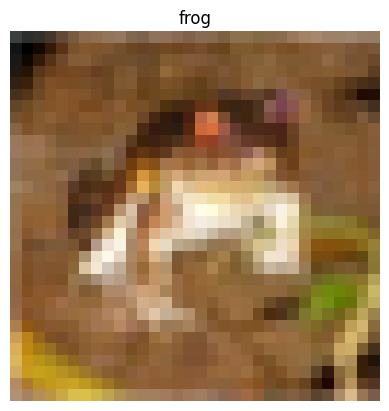

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#Step 1: Define transformations for the dataset (usually required)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

# Step 2: Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

# Step 3: Define classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Step 4: Fetch one batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Step 5: Display one image from the batch
img = torchvision.utils.make_grid(images[0])  # Create grid of images, take first image from batch
img = img.permute(1, 2, 0)  # Reorder dimensions for matplotlib (C, H, W) -> (H, W, C)

# Step 6: Show image with labels
plt.imshow(img)
plt.title(classes[labels[0]])
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [9]:
dataiter = iter(trainloader)
cifar_im = next(dataiter)[0]
cifar_im.shape

torch.Size([4, 3, 32, 32])

In [17]:
S = 128 # channel dim
W = 227 # width
H = 227 # height
batch_size = 10

x = torch.randn(batch_size, S, H, W)

size = 32 # patch size
stride = 32 # patch stride
patches = x.unfold(1, size, stride).unfold(2, size, stride).unfold(3, size, stride)
print(patches.shape)

torch.Size([10, 4, 7, 7, 32, 32, 32])


Dividing images into patches and then reconstructing them again

In [10]:
#Getting data

#My own
#file_paths
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128

train_data = mae_kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = mae_kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  mae_kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = mae_collate_fn, num_workers = 60)

print(f'Length of test data: {len(test_data)}')

#CIFAR-10 data
#Step 1: Define transformations for the dataset (usually required)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  # Convert images to tensors
])

# Step 2: Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

# Step 3: Define classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Length of test data: 114000
Files already downloaded and verified
GPU is available. Using GPU.


In [11]:
#loading data 
dl = kids_test_loader
for i,(x,y) in enumerate(dl):
    print(len(dl))
    #random.shuffle(dg.file_paths)
    print(x.shape)
    print(y.shape)
    kids_im = x
    if i == 1:
        break
#kids_im = remove_channel(kids_im[0],3) #remove channel and choose a element

# cifar 10 loading
dataiter = iter(trainloader)
images, labels = next(dataiter)
cifar_im = next(dataiter)[0]
cifar_im.shape

593
torch.Size([192, 1, 4, 128, 128])
torch.Size([192, 2])
593
torch.Size([192, 1, 4, 128, 128])
torch.Size([192, 2])


torch.Size([4, 3, 224, 224])

In [12]:
images.shape

torch.Size([4, 3, 224, 224])

In [38]:
kids_im.shape

torch.Size([1, 3, 128, 128])

In [1]:
#Displaying kids images

# Plot each image
test_im = kids_im[13].squeeze()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(test_im[i], cmap = "viridis")
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')
plt.show()

NameError: name 'kids_im' is not defined

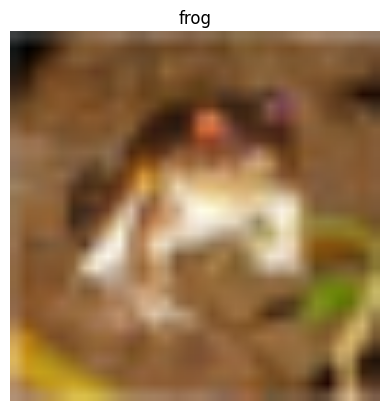

In [14]:
#displaying kids images
img = torchvision.utils.make_grid(images[0])  # Create grid of images, take first image from batch
img = img.permute(1, 2, 0)  # Reorder dimensions for matplotlib (C, H, W) -> (H, W, C)

# Step 6: Show image with labels
plt.imshow(img)
plt.title(classes[labels[0]])
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [18]:
#Creating a patching algorithm
PATCH_SIZE = 16
class Patches_2(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, images):
        bs, c, h, w = images.shape
        patches = self.unfold(images) #after unfold[1, 768, 196])
        print(f"after unfold{patches.shape}") #after view[1, 3, 16, 16, 196])
        print(f"after view{patches.view(bs, c, self.patch_size,self.patch_size, -1).shape}")
        patches = patches.view(bs, c, self.patch_size,self.patch_size, -1).permute(0,4,1,2,3)#after view[1, 3, 16, 16, 196])   
        return patches
    #after reshape torch.Size([1, 3, 14, 16, 14, 16])    
    #x = torch.einsum('nchpwq->nhwpqc', x) #einstein summation same as permute function
    #print(x.shape)
    #x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        plt.figure(figsize=(4, 4))
        #print(f"plotting image{images.shape}")
        plt.imshow(ToPILImage()(images.squeeze().cpu()))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1])) #calc number of rows/cols
        #print(f"n {n}")
        fig = plt.figure(figsize=(4, 4))
        grid = ImageGrid(fig, 111, nrows_ncols = (n,n), axes_pad = 0.1)
        
        for i, ax in enumerate(grid):
            patch = patches.squeeze()[i] 
            print(f" Cheking the patch {patch.shape}")
            if patch.shape == torch.Size([3,patch.shape[1],patch.shape[1]]):
                print("inf if clause")
                patch = patch.permute(2, 1, 0).numpy() #change shape
            #print(f"after changing shape{patch.shape}")
            #patch = patch.permute(1, 2, 0) #change shape
            if i == 0:
                print(f"Shape of patch {patch.shape}")
                
            #ax.imshow(ToPILImage()(patch.squeeze().cpu())) 
            ax.imshow(ToPILImage()(patch.squeeze()))    
            #ax.imshow(patch)
            ax.axis("off")
            plt.axis("off")
        plt.show()

#def show_image(image):
def remove_channel(tensor, channel_to_remove):
    """
    Remove a specific channel from a PyTorch tensor representing images.
    
    Args:
    - tensor (torch.Tensor): Input tensor with shape [batch_size, channels, height, width].
    - channel_to_remove (int): Index of the channel to remove.
    
    Returns:
    - torch.Tensor: Tensor with the specified channel removed, shape [batch_size, channels-1, height, width].
    """
    # Ensure channel_to_remove is within valid range
    assert 0 <= channel_to_remove < tensor.size(1), f"Invalid channel index: {channel_to_remove}"
    
    # Method 1: Using torch.cat and torch.unbind
    tensor_without_channel = torch.cat((tensor[:, :channel_to_remove], tensor[:, channel_to_remove+1:]), dim=1)
    
    # Alternative Method 2: Using torch.index_select
    # indices = list(range(tensor.size(1)))  # Create a list of indices [0, 1, 2, ...]
    # indices.pop(channel_to_remove)  # Remove the specified channel index
    # tensor_without_channel = torch.index_select(tensor, 1, torch.tensor(indices))
    
    return tensor_without_channel

In [19]:
import torch

# Create an example tensor
tensor = torch.randn(3, 16, 16)
print(tensor.shape)

# Check if the tensor has the shape [3, 16, 16]
if tensor.shape == torch.Size([3, 16, 16]):
    print("The tensor has the shape [3, 16, 16].")
else:
    print("The tensor does not have the shape [3, 16, 16].")

torch.Size([3, 16, 16])
The tensor has the shape [3, 16, 16].


In [80]:
patches.shape

torch.Size([1, 196, 3, 16, 16])

torch.Size([1, 3, 224, 224])
after unfoldtorch.Size([1, 768, 196])
after viewtorch.Size([1, 3, 16, 16, 196])
patches torch.Size([1, 196, 3, 16, 16])


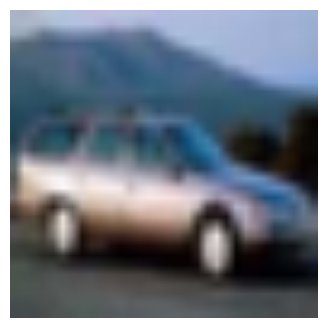

 Cheking the patch torch.Size([3, 16, 16])
inf if clause
Shape of patch (16, 16, 3)
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Che

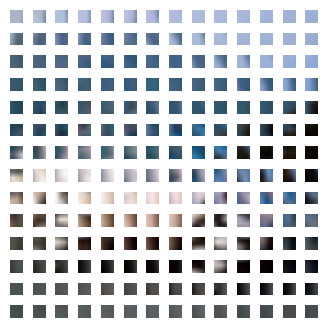

In [31]:
PATCH_SIZE = 16

images =  cifar_im[0].unsqueeze(0)
print(images.shape)
patch_layer = Patches_2(patch_size=PATCH_SIZE)
patches = patch_layer(images)
print(f"patches {patches.shape}")
#len(patches[2])

patch_layer.show_patched_image(images, patches)

torch.Size([1, 3, 128, 128])
after unfoldtorch.Size([1, 768, 64])
after viewtorch.Size([1, 3, 16, 16, 64])
torch.Size([1, 64, 3, 16, 16])


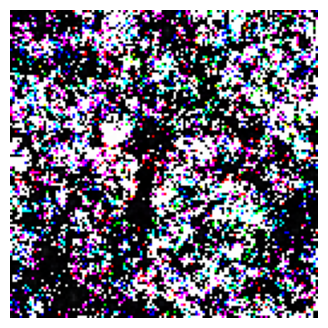

 Cheking the patch torch.Size([3, 16, 16])
inf if clause
Shape of patch (16, 16, 3)
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Cheking the patch torch.Size([3, 16, 16])
inf if clause
 Che

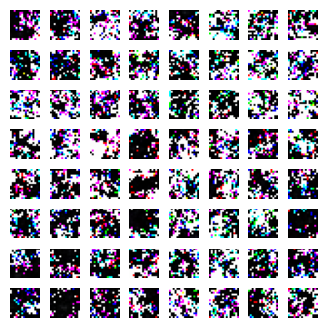

In [21]:
#ffor kids I remove one channel for compability
kids_im[0].shape
kids_im = remove_channel(kids_im[0],3) #remove channel and choose a element
PATCH_SIZE = 16
#kids_im = remove_channel(kids_im[0],3) #remove channel and choose a element
images =  kids_im
print(images.shape)
patch_layer = Patches_2(patch_size=PATCH_SIZE)
patches = patch_layer(images)
print(patches.shape)
#len(patches[2])

patch_layer.show_patched_image(images, patches)

So the code implementation will be based on multiple sources:

*The paper:[link text](https://arxiv.org/pdf/2111.06377)

*Pytorch implementation of paper: [link text](https://heartbeat.comet.ml/self-supervised-vision-with-masked-autoencoder-9e2372138142!)

*Tensorflow implementation  of MAE: [link text](https://keras.io/examples/vision/masked_image_modeling/)


In [72]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding """
    def __init__(self, img_size=(224, 224), patch_size=(16, 16), in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


def get_sinusoid_encoding_table(n_position, d_hid): 
  
    def get_position_angle_vec(position): 
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)] 

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)]) 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # dim 2i 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # dim 2i+1 
    return torch.FloatTensor(sinusoid_table).unsqueeze(0) 

In [55]:
img_size= (224,224) 
patch_size= (16,16)
in_chans=3
embed_dim=768
norm_layer=nn.LayerNorm
num_classes=0
num_features = 768 # each feature is the patch 16*16
embed_dim = 768 #so I will have this many embeddings

In [73]:
#The functions:
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)#get patch embeddings
pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)
pos_embed.type_as(x).to(x.device).clone().detach()
num_patches = patch_embed.num_patches#define number of paches trough the PatchEmbed func

In [65]:
images.shape

torch.Size([1, 3, 224, 224])

In [77]:
#encoder forward explalnation

x = patch_embed(images)
sincos_table = pos_embed.type_as(x).to(x.device).clone().detach()
result = x + sincos_table

In [ ]:
class Encoder(nn.Module)
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=nn.LayerNorm, num_classes=0, **block_kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        # Patch embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # Positional encoding
        self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(**block_kwargs) for i in range(depth)])  # various arguments are not shown here for brevity purposes
        self.norm =  norm_layer(embed_dim)
        
        # Classifier (for fine-tuning only)
        self.fc_norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask):
        x = self.patch_embed(x) #get pach embeddings (batch_size, num_patches_per_channels, num_embeddings)
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach() #detach basically says to the class Module that do not track gradients since this is afixed table
        
        B, _, C = x.shape
        return x

In [ ]:
class Encoder(nn.Module)
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=nn.LayerNorm, num_classes=0, **block_kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        # Patch embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # Positional encoding
        self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(**block_kwargs) for i in range(depth)])  # various arguments are not shown here for brevity purposes
        self.norm =  norm_layer(embed_dim)
        
        # Classifier (for fine-tuning only)
        self.fc_norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask):
        x = self.patch_embed(x)
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach()
        B, _, C = x.shape
        if mask is not None:  # for pretraining only
            x = x[~mask].reshape(B, -1, C) # ~mask means visible
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        if self.num_classes > 0:  # for fine-tuning only
            x = self.fc_norm(x.mean(1))  # average pooling
            x = self.head(x)
        return x

In [37]:
# try patchify 2 from the facebook  stuff
def patchify_fb(imgs):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = 16#self.patch_embed.patch_size[0]
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    print(f"after reshape {x.shape}")
    x = torch.einsum('nchpwq->nhwpqc', x) #einstein summation same as permute function
    print(x.shape)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    print(x.shape)
    return x

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = 16#self.patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [39]:
patches.shape

torch.Size([1, 196, 768])

In [1]:
patches = patchify_fb(images)
def plot_patches(patches, patch_size=16):
    num_patches = patches.shape[1]
    grid_size = int(num_patches**0.5)  # Assuming square grid for simplicity

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(4, 4))

    for i in range(grid_size):
        for j in range(grid_size):
            patch_idx = i * grid_size + j
            if patch_idx < num_patches:
                patch_vector = patches[0, patch_idx]
                patch_reshaped = patch_vector.reshape(patch_size,patch_size, 3)
                patch_np = patch_reshaped.numpy()
                #patch_permuted = patch_reshaped.permute(0,1, 2)
                #patch_np = patch_permuted.numpy()
                axes[i, j].imshow(patch_np)
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots
    
    plt.show()

# Plot the patches
plot_patches(patches)
print(patches.shape)

NameError: name 'patchify_fb' is not defined

In [30]:
images.shape

torch.Size([1, 3, 128, 128])

after reshape torch.Size([1, 3, 2, 112, 2, 112])
torch.Size([1, 2, 2, 112, 112, 3])
torch.Size([1, 4, 37632])
torch.Size([1, 4, 37632])


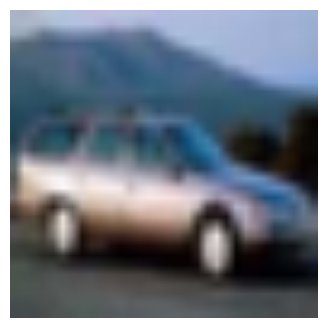

 Cheking the patch torch.Size([16, 16, 3])
Shape of patch torch.Size([16, 16, 3])


ValueError: pic should not have > 4 channels. Got 16 channels.

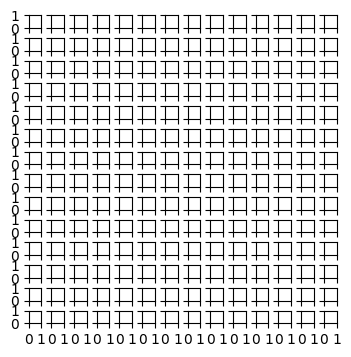

In [34]:
x_fb = patchify_fb(images)
print(x_fb.shape)
x_fb_reshaped = x_fb.view(1, 196, 16, 16, 3)
#print(x_fb_reshaped.shape)
patch_layer.show_patched_image(images, x_fb_reshaped)
#x_fb = unpatchify_fb(x_fb)


In [99]:
x_fb.shape

torch.Size([1, 3, 224, 224])